本次实验以AAAI 2014会议论文数据为基础，要求实现或调用无监督聚类算法，了解聚类方法。

### 任务介绍
每年国际上召开的大大小小学术会议不计其数，发表了非常多的论文。在计算机领域的一些大型学术会议上，一次就可以发表涉及各个方向的几百篇论文。按论文的主题、内容进行聚类，有助于人们高效地查找和获得所需要的论文。本案例数据来源于AAAI 2014上发表的约400篇文章，由[UCI](https://archive.ics.uci.edu/ml/datasets/AAAI+2014+Accepted+Papers!)公开提供，提供包括标题、作者、关键词、摘要在内的信息，希望大家能根据这些信息，合理地构造特征向量来表示这些论文，并设计实现或调用聚类算法对论文进行聚类。最后也可以对聚类结果进行观察，看每一类都是什么样的论文，是否有一些主题。

基本要求：
1. 将文本转化为向量，实现或调用无监督聚类算法，对论文聚类，例如10类（可使用已有工具包例如sklearn）；
2. 观察每一类中的论文，调整算法使结果较为合理；
3. 无监督聚类没有标签，效果较难评价，因此没有硬性指标，跑通即可，主要让大家了解和感受聚类算法，比较简单。

扩展要求：
1. 对文本向量进行降维，并将聚类结果可视化成散点图。

注：group和topic也不能完全算是标签，因为
1. 有些文章作者投稿时可能会选择某个group/topic但实际和另外group/topic也相关甚至更相关；
2. 一篇文章可能有多个group和topic，作为标签会出现有的文章同属多个类别，这里暂不考虑这样的聚类；
3. group和topic的取值很多，但聚类常常希望指定聚合成出5/10/20类；
4. 感兴趣但同学可以思考利用group和topic信息来量化评价无监督聚类结果，不作要求。

提示：
1. 高维向量的降维旨在去除一些高相关性的特征维度，保留最有用的信息，用更低维的向量表示高维数据，常用的方法有PCA和t-SNE等；
2. 降维与聚类是两件不同的事情，聚类实际上在降维前的高维向量和降维后的低维向量上都可以进行，结果也可能截然不同；
3. 高维向量做聚类，降维可视化后若有同一类的点不在一起，是正常的。在高维空间中它们可能是在一起的，降维后损失了一些信息。

### 导入包
注意nltk是做自然语言处理的常用包，里面很多组件需要下载资源，调用一次即可

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf文本向量化
from sklearn.cluster import KMeans, AgglomerativeClustering # 聚类方法
from sklearn.manifold import TSNE # tSNE降维
from sklearn.decomposition import PCA # PCA
import re
import nltk
from scipy import sparse # 稀疏矩阵
import seaborn as sns # 作图
from collections import Counter

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
RANDOM_STATE = 2020

### 读入数据
注意数据中有少数空值，需要填充为空字符串

In [2]:
csv_data = './data/[UCI] AAAI-14 Accepted Papers - Papers.csv' # 数据文件路径
data_df = pd.read_csv(csv_data) # 读入csv
data_df = data_df.fillna('') # 填充空值为空字符串
data_df.info() # 输出数据大致信息
data_df.head() # 输出前5行

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
title       398 non-null object
authors     398 non-null object
groups      398 non-null object
keywords    398 non-null object
topics      398 non-null object
abstract    398 non-null object
dtypes: object(6)
memory usage: 18.8+ KB


,title,authors,groups,keywords,topics,abstract
0,Kernelized Bayesian Transfer Learning,Mehmet Gönen and Adam A. Margolin,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Transfer learning considers related but distin...
1,"""Source Free"" Transfer Learning for Text Class...","Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Transfer learning uses relevant auxiliary data...
2,A Generalization of Probabilistic Serial to Ra...,Haris Aziz and Paul Stursberg,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,The probabilistic serial (PS) rule is one of t...
3,Lifetime Lexical Variation in Social Media,"Liao Lizi, Jing Jiang, Ying Ding, Heyan Huang ...",NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,As the rapid growth of online social media att...
4,Hybrid Singular Value Thresholding for Tensor ...,"Xiaoqin Zhang, Zhengyuan Zhou, Di Wang and Yi Ma",Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...,"In this paper, we study the low-rank tensor co..."


### 文本向量化

In [3]:
def column2vector(df, column, **kwargs): # 将DataFrame某一列转化为文本向量
    docs = df[column].tolist() # 取出所有文本字符串
    vectorizer = TfidfVectorizer(**kwargs) # 用tf-idf向量化
    x = vectorizer.fit_transform(docs) # 返回值是一个稀疏矩阵
#     print(vectorizer.vocabulary_)
    return x


def author_tokenizer(string): # 作者列分词
    authors = re.split("\s+and\s+|\s*,\s*", string) # 根据逗号或者and进行分词
    return authors

def word_tokenizer(string): # 一般文本列分词
    words = nltk.tokenize.word_tokenize(string) # 先切词
    stemmer = nltk.stem.SnowballStemmer('english') # 使用nltk词干化工具
    words = [stemmer.stem(w) for w in words] # 对每个词词干化
#     lemma = nltk.wordnet.WordNetLemmatizer() # 这里也可以做lemma，但是lemma要求变换后的词也是有意义的所以更严格
#     words = [lemma.lemmatize(w).lower() for w in words] 
    stopwords = nltk.corpus.stopwords.words('english') # 使用nltk的停用词
    words = [w for w in words if w not in stopwords] # 去除停用词
    return words

author_tokenizer('Xiaoqin Zhang, Zhengand Zhou, Di Wang and Yi Ma')
# word_tokenizer('Kernelized Bayesian Transfer Learning')

# x = column2vector(data_df, column='authors', tokenizer=author_tokenizer)
# x = column2vector(data_df, column='abstract', tokenizer=word_tokenizer, max_df=0.9, min_df=0.01)
# print(x.toarray())
# print(x.shape)

['Xiaoqin Zhang', 'Zhengand Zhou', 'Di Wang', 'Yi Ma']

### 将每一列向量化

In [4]:
title_x = column2vector(data_df, column='title', tokenizer=word_tokenizer)
print('title', title_x.shape)
authors_x = column2vector(data_df, column='authors', tokenizer=author_tokenizer)
print('authors', authors_x.shape)
groups_x = column2vector(data_df, column='groups', tokenizer=word_tokenizer)
print('groups', groups_x.shape)
keywords_x = column2vector(data_df, column='keywords', tokenizer=word_tokenizer)
print('keywords', keywords_x.shape)
topics_x = column2vector(data_df, column='topics', tokenizer=word_tokenizer)
print('topics', topics_x.shape)
abstract_x = column2vector(data_df, column='abstract', tokenizer=word_tokenizer, max_df=0.9, min_df=0.01)
print('abstract', abstract_x.shape)

title (398, 1125)
authors (398, 1105)
groups (398, 64)
keywords (398, 1051)
topics (398, 307)
abstract (398, 1215)


### 生成文本向量
这里我们简单处理，将所有向量进行拼接。但作为聚类的依据，实际上有非常多不同的处理方式可以尝试。比如先对每一列的向量降维后再聚类、或者对每一列特征进行加权，各有优劣。感兴趣的同学可以尝试对比其效果。

In [5]:
all_x = sparse.hstack([title_x, authors_x, groups_x, keywords_x, topics_x, abstract_x]) # 稀疏向量拼接
print(all_x.shape)

(398, 4867)


### 聚类算法

KMeans和层次聚类方法可以指定聚类的类别数目，但是基于密度的聚类方法例如DBSCAN一般不能指定。

In [6]:
model = KMeans(n_clusters=10, random_state=RANDOM_STATE) # KMean聚类
# model = AgglomerativeClustering(n_clusters=10, affinity='euclidean') # 层次聚类，欧式距离
# model = AgglomerativeClustering(n_clusters=10, affinity='cosine', linkage='average') # 层次聚类，余弦距离
all_y = model.fit_predict(all_x)
print(all_y) # 输出标签
print(Counter(all_y)) # 各个类数目

[0 0 4 9 2 2 2 2 7 0 1 0 0 7 8 2 4 3 7 2 9 5 9 0 0 9 3 1 7 2 4 1 0 0 4 5 0
 4 2 4 0 5 2 2 4 5 0 2 7 1 7 7 7 9 1 7 5 4 9 0 4 0 7 3 7 4 5 4 2 5 4 6 0 0
 2 3 5 4 2 4 3 9 7 2 2 7 0 9 2 0 0 3 8 9 0 1 2 3 2 9 5 7 2 9 5 6 4 8 2 5 4
 8 2 5 9 6 9 9 0 0 9 0 9 8 4 2 0 8 0 8 0 5 5 0 4 4 2 2 8 9 5 0 1 7 0 3 1 0
 8 4 0 2 9 9 0 6 7 8 9 9 2 4 5 0 6 3 4 7 8 9 5 4 8 5 5 2 2 6 4 5 5 4 2 2 5
 6 9 3 4 3 4 4 6 0 0 5 8 3 6 0 6 1 9 9 7 5 8 2 2 7 0 2 5 9 2 3 8 0 8 7 2 2
 2 2 4 0 9 3 9 2 5 2 0 4 7 1 9 8 6 2 0 9 0 0 7 9 2 1 0 0 1 2 4 0 0 7 1 2 0
 2 0 4 7 2 0 4 1 0 7 7 4 0 4 6 0 0 2 6 0 5 9 8 0 1 6 2 2 5 0 7 7 5 1 0 5 4
 9 7 0 0 0 2 0 4 4 2 9 4 8 2 1 5 8 4 1 8 0 4 0 6 4 5 2 5 5 5 5 0 2 0 4 0 1
 6 6 2 4 4 6 2 5 8 3 4 2 8 8 4 5 2 2 7 5 0 5 0 5 8 0 4 2 9 5 2 0 0 4 3 7 0
 4 6 0 2 5 9 7 8 2 2 8 9 5 5 9 9 6 1 0 6 4 8 9 7 7 5 9 0]
Counter({0: 76, 2: 65, 4: 51, 5: 46, 9: 41, 7: 34, 8: 28, 6: 21, 1: 20, 3: 16})


### 查看每个类别的数据
可以看到聚类结果还算可以接受，一些类别有明显主题：

0. 新颖的机器学习算法
1. 启发式搜索和优化
2. 机器学习的具体应用
3. 计算可持续性
4. 博弈论和经济模式
5. 知识表示与推理
6. 搜索和约束满足
7. 网络相关的人工智能如搜索和推荐
8. 规划调度
9. NLP、认知科学

如果调整使用其他的文本向量、参数、算法可能出现截然不同的结果，例如出现明显的“计算机视觉“相关类别

In [7]:
cluster_index = {} # 记录每个类别的index
for idx, i in enumerate(all_y): # 遍历每个聚类label
    if i not in cluster_index: # 如果是新的类
        cluster_index[i] = [] # 新建一个列表记录index
    cluster_index[i].append(idx) # 记录index
data_df[['title', 'groups', 'topics']].iloc[cluster_index[9]] # 输出对应类别的文章标题、group和topic

,title,groups,topics
3,Lifetime Lexical Variation in Social Media,NLP and Text Mining (NLPTM),AIW: Web personalization and user modeling\nNL...
20,The Importance of Cognition and Affect for Art...,Cognitive Modeling (CM)\nCognitive Systems (CS...,CM: Simulating Humans\nCS: Problem solving and...
22,Scalable Complex Contract Negotiation With Str...,Multiagent Systems (MAS),MAS: Distributed Problem Solving\nMAS: Mechani...
25,Towards Understanding Unscripted Gesture and L...,Humans and AI (HAI)\nNLP and Machine Learning ...,APP: Other Applications\nHAI: Language Acquisi...
53,Adaptive Multi-Compositionality for Recursive ...,NLP and Machine Learning (NLPML),NLPML: Natural Language Processing (General/Ot...
58,Robust Visual Robot Localization Across Season...,Robotics (ROB),"ROB: Localization, Mapping, and Navigation"
81,Extracting Keyphrases from Research Papers usi...,NLP and Text Mining (NLPTM),NLPTM: Information Extraction\nNLPTM: Natural ...
87,Minimising Undesired Task Costs in Multi-robot...,Multiagent Systems (MAS)\nRobotics (ROB),GTEP: Auctions and Market-Based Systems\nMAS: ...
93,Can Agent Development Affect Developer's Strat...,Cognitive Modeling (CM)\nHumans and AI (HAI),CM: Simulating Humans\nHAI: Understanding Peop...
99,Generating Content for Scenario-Based Serious-...,Game Playing and Interactive Entertainment (GPIE),GPIE: Procedural Content Generation


### 聚类可视化
可以将高维数据降维到2维平面上进行可视化，点的颜色为类别。
聚类正常的化一般有一些清楚的类别，如果完全混在一起可能聚类结果不太好。
但一些高维上接近的点在降维后也可能被分开。

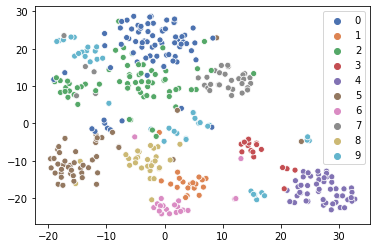

In [8]:
tsne_x = TSNE(random_state=RANDOM_STATE, perplexity=30).fit_transform(all_x) # tSNE降维
sns.scatterplot(x=tsne_x[:,0], y=tsne_x[:,1], hue=all_y, palette="deep") # 散点图